<a href="https://colab.research.google.com/github/BennoKrojer/ML2/blob/main/Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP 551 - Mini Project 2

Starting point: [sklearn text data tutorial](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)  

Recommended Base Model: [sklearn's Logistic Regression package](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV

### Data Loading

In [3]:
!wget https://raw.githubusercontent.com/BennoKrojer/ML2/main/fake_news_data/fake_news_train.csv
!wget https://raw.githubusercontent.com/BennoKrojer/ML2/main/fake_news_data/fake_news_val.csv
!wget https://raw.githubusercontent.com/BennoKrojer/ML2/main/fake_news_data/fake_news_test.csv

--2021-10-19 00:08:38--  https://raw.githubusercontent.com/BennoKrojer/ML2/main/fake_news_data/fake_news_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63830815 (61M) [text/plain]
Saving to: ‘fake_news_train.csv’

fake_news_train.csv 100%[===================>]  60.87M   150MB/s    in 0.4s    

2021-10-19 00:08:43 (150 MB/s) - ‘fake_news_train.csv’ saved [63830815/63830815]

--2021-10-19 00:08:43--  https://raw.githubusercontent.com/BennoKrojer/ML2/main/fake_news_data/fake_news_val.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 20

In [4]:
!ls

fake_news_test.csv  fake_news_train.csv  fake_news_val.csv  sample_data


In [5]:
raw_data_train = pd.read_csv("fake_news_train.csv")
raw_data_val   = pd.read_csv("fake_news_val.csv")
raw_data_test  = pd.read_csv("fake_news_test.csv")

raw_data_train.head
raw_data_train.columns

Index(['text', 'label'], dtype='object')

### Data Pre-Processing
To preform machine learning on text, need to first extract features for the text.

In [77]:
# Seperate raw data into text and label
raw_data_train_text = raw_data_train["text"]
raw_data_train_label = raw_data_train["label"]

# Convert to numpy array so it is easier to work with
X_train = np.asarray(raw_data_train_text)

# Create numpy array to store target labels
Y_train = np.asarray(raw_data_train_label)
Y_train

print(X_train.shape)
print(Y_train.shape)

(20000,)
(20000,)


In [76]:
# Seperate raw data for validation set
raw_data_val_text = raw_data_val["text"]
raw_data_val_label = raw_data_val["label"]
X_val = np.asarray(raw_data_val_text)
Y_val = np.asarray(raw_data_val_label)
Y_val
print(X_val.shape)
print(Y_val.shape)

(2000,)
(2000,)


In [78]:
# Seperate raw data for test set
raw_data_test_text = raw_data_test["text"]
raw_data_test_label = raw_data_test["label"]
X_test = np.asarray(raw_data_test_text)
Y_test = np.asarray(raw_data_test_label)
print(X_test.shape)
print(Y_test.shape)

(3000,)
(3000,)


#### Bag of Words (Vectorizing)
For the bag of words method, each word in the training data set is given an integer ID, then for each data sample, count the number of occurrences of each word, and store the count of each word as a feature for the training sample.  

Ex:  
`Data sample 'i' = "The quick brown fox jumped over the brown dog"`  
`if id for word "brown" = 3`  
`store X[i, 3] = 2 (word count)`    

This method implies that the number of features = number of unique words in all training samples. Number features is typically > 100,000.  

Thus, if every sample had every word, then the size of the matrix would be 100,000 x 100,000 x 4 bytes, which is not very practical. Luckily, most features will be zero for most samples, as most features only contain a small subset of the total set of words in the data set. For this reason, we usually say that the bag of words features array are *high-dimensional sparse data sets*.  

Will use scipy.sparse matrix to store data set features




In [9]:
# Use sklearn.feature_extraction.text.CountVectorizer
# To build a dictionary of features, and transform data samples into feature vectors
count_vect = CountVectorizer()

# training feature vectors
X_train_counts = count_vect.fit_transform(raw_data_train_text)
X_train_counts.shape

(20000, 145402)

Look into removing junk and/or non-english words.

In [119]:
# Peak at output of count vectorizer
count_vect.vocabulary_.get(u'algorithm')
#count_vect.vocabulary_.get(u' ')
#sorted_vocab = np.sort(count_vect.vocabulary_, axis=0)
sorted(count_vect.vocabulary_.items(), key=lambda x : x[1], reverse=True)
#count_vect.vocabulary_

[('𝙉𝘼𝙏𝙄𝙊𝙉', 145401),
 ('𝙃𝙀𝘼𝙏', 145400),
 ('𝘸𝘪𝘵𝘩', 145399),
 ('𝘭𝘶𝘷', 145398),
 ('𝘣𝘰𝘺', 145397),
 ('𝗥𝗶𝗱𝘇𝘂𝗮𝗻', 145396),
 ('𝗔𝘆𝘀𝗵𝗮', 145395),
 ('𝖎𝖏𝖚', 145394),
 ('𝕽𝖆𝖓𝖉𝖞', 145393),
 ('𝕟𝕖𝕣𝕖𝕒', 145392),
 ('𝔍𝔲𝔫𝔞𝔦𝔡', 145391),
 ('𝒽𝒶𝓃𝓃𝒶𝒽', 145390),
 ('𝑩𝑳𝑯', 145389),
 ('ａｎａｒ𝕔𝕙𝕚𝕔', 145388),
 ('ﬁnger', 145387),
 ('직은', 145386),
 ('위한', 145385),
 ('것들을', 145384),
 ('黒人極太二穴ファック', 145383),
 ('解禁', 145382),
 ('綾地', 145381),
 ('瑞士警方调查狂欢节', 145380),
 ('煩わしい税関手続き', 145379),
 ('淫語中出しソープ62', 145378),
 ('浮気女緊縛公開処刑', 145377),
 ('梨々花', 145376),
 ('昭和はs', 145375),
 ('日間99位', 145374),
 ('日間75位', 145373),
 ('日間100位', 145372),
 ('数量限定', 145371),
 ('彩葉みおり', 145370),
 ('平成はh', 145369),
 ('寧々ちゃん', 145368),
 ('媚薬bdsm', 145367),
 ('女子アナ志望の女子大生21才', 145366),
 ('君島みお', 145365),
 ('发布于', 145364),
 ('北山かんな', 145363),
 ('令和の英字略称はr', 145362),
 ('令和18年', 145361),
 ('令和', 145360),
 ('中国がスイスと絶交した日', 145359),
 ('三k党服饰事件', 145358),
 ('一楽拉面', 145357),
 ('ヤバいとおもったらrt', 145356),
 ('ミスキャンパス高身長で清楚', 145355),
 ('パンティと生写真とデジタル写真集付き', 1453

#### Occurences -> Frequencies (Transforming)
Occurence count is a good start, but is skewed towards longer documents. Longer text will on average have more occurences than shorter text. To compensate for this, we can look at term frequencies which is the number of occurences of a word in some text, divided by the total number of words in that text.  

#### Downscale Word Weights
Another pre-processing technique for text is to give higher weights to rarer words, and lower weights to words that appear frequently in the overall set of text. This is down by downscaling the weights of words that appear frequently in all texts.  

These two approaches can be combined into something called tf-idf, or Term Frequency times Inverse Document Frequency. Can be computed using sklearn->TfidfTransformer.

In [11]:
tfidf_transformer = TfidfTransformer()
# fit_transform combines fit and transform into one step
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(20000, 145402)

Visualize word weights (after tf-idf)

In [105]:
X_train_tfidf

<20000x145402 sparse matrix of type '<class 'numpy.float64'>'
	with 5141820 stored elements in Compressed Sparse Row format>

#### Scaling Features


### Model Training
Linear model - Logistic Regression using sklearn.linear_model.LogisticRegression  

Start with default parameters for Logistic Regression classifier:  
- penalty  - norm of the penalty (default = 'l2')  
- tol      - tolerance for stopping criteria (default = 1e-4)  
- max_iter - Maximum number of iterations taken for the solvers to converge (default = 100) 

can also specify # cpus to use
n_jobs = default = None: means 1, use -1 to specify all processors

#### Fit

In [13]:
# is model same as classifier?
# clf = classifier
clf = LogisticRegression(penalty='l2', tol=1e-4, max_iter=1000)

# fit classifier
clf.fit(X_train_tfidf, Y_train)



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [60]:
# Score
Y_score = clf.decision_function(X_test)
Y_score

ValueError: ignored

#### Validate

In [14]:
# Pre process validation data in same way as train data
# But only transform data, as count_vectorizer and tfidf_transformer have already been
# fit to training data (and don't want to fit to validation or test data)

X_val_counts = count_vect.transform(raw_data_val_text)
print("X_val_counts.shape: ", X_val_counts.shape)
X_val_tfidf = tfidf_transformer.transform(X_val_counts)
print("X_val_tfidf.shape: ", X_val_tfidf.shape)

val_pred = clf.predict(X_val_tfidf)

print("val_pred.shape: ", val_pred.shape)
print("Y_val.shape: ", Y_val.shape)

# Compare predicitions to labels
np.mean(val_pred == Y_val)

X_val_counts.shape:  (2000, 145402)
X_val_tfidf.shape:  (2000, 145402)
val_pred.shape:  (2000,)
Y_val.shape:  (2000,)


0.731

### Pipeline
In order to make our sequence of pre-processing and classifying easier, sklearn allows us to create a pipeline to apply the operations to a set of data: vectorizer->transformer->classifier.  
- Vectorizer ("vect") = Bag of Words, transform text to counts of words in text
- Transformer ("tfidf") = TF-IDF transform
- Classifier ("lr-clf") = Logistic Regression classifier

In [15]:
text_pipeline = Pipeline([
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer()),
    ("lr-clf", LogisticRegression(max_iter=500)),
])

In [49]:
# Can now train using a single command / function
text_pipeline.fit(raw_data_train_text, Y_train)

(20000,)


In [17]:
# Train pipeline using train set
text_pipeline.score(raw_data_train_text, Y_train)

0.85525

In [18]:
# Predict labels for train set using pipeline
Y_pred = text_pipeline.predict(raw_data_train_text)
#print("Y_pred.shape: ", Y_pred.shape, ", Y_train.shape: ", Y_train.shape)
acc = np.mean(Y_pred == Y_train)
print(acc)

0.85525


In [19]:
# Validate using pipeline
Y_pred = text_pipeline.predict(raw_data_val_text)
#print("Y_pred.shape: ", Y_pred.shape, ", Y_val.shape: ", Y_val.shape)
acc = np.mean(Y_pred == Y_val)
print(acc)

0.731


### Parameter Tuning

First using grid search and then random search or other methods..

tol: float, default=1e-4
Tolerance for stopping criteria.

C: float, default=1.0
Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

In [100]:
parameters = {
    'vect__ngram_range': [(1,1), (1,2)],
    'tfidf__use_idf': (True, False),
    'lr-clf__penalty': [None, 'l1', 'l2', 'elasticnet'],
    'lr-clf__tol': [1e-4, 1e-3, 1e-2], # tolerance for gradient decsent stopping criteria
    'lr-clf__C': [1,2], # regularization parameter
    'lr-clf__random_state': [None, 1], # shuffled vs unshuffled
    'lr-clf__max_iter': [100, 500, 1000, 5000]
}
parameters = {
    'vect__ngram_range': [(1,1), (1,2)]
}
print(text_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'lr-clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'lr-clf__C', 'lr-clf__class_weight', 'lr-clf__dual', 'lr-clf__fit_intercept', 'lr-clf__intercept_scaling', 'lr-clf__l1_ratio', 'lr-clf__max_iter', 'lr-clf__multi_class', 'lr-clf__n_jobs', 'lr-clf__penalty', 'lr-clf__random_state', 'lr-clf__solver', 'lr-clf__tol', 'lr-clf__verbose', 'lr-clf__warm_start'])


In [101]:
gs_clf = GridSearchCV(text_pipeline, parameters, cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, Y_train)
gs_clf.predict(X_test)
gs_clf.best_score_
gs_clf.best_params_

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.71415

Random Search with All Params

In [ ]:
# implement RandomSearch

### Model Evalutation (testing)
Now test performance of model using testing data

#### Test accuracy

In [20]:
# Test model acc with test data
Y_pred = text_pipeline.predict(raw_data_test_text)
acc = np.mean(Y_pred == Y_test)
print(acc)

0.71


In [80]:
# Get score
#print(X_train.ravel().shape)
#print(Y_train.shape)
#print(Y_test.shape)
fitted_pipeline = text_pipeline.fit(X_train.ravel(), Y_train)
#print(len(Y_train.tolist()))
Y_score = fitted_pipeline.decision_function(X_test)
Y_score.shape

(3000,)

In [81]:
X_test.shape

(3000,)

#### Model Metrics

**double check this** might be backwards  
Confusion Matrix: Positive = fake news, Negative = not fake news  

          |          | Predicted	    |
          |          | Positive       |	Negative  
----------|----------|----------------|------------------
Observed  |	Positive |	TP (# of TPs) |	FN (# of FNs)  
          | Negative |	FP (# of FPs) |	TN (# of TNs)  


In [85]:
# Confusion matrix for binary classification: 
conf_matrix = metrics.confusion_matrix(Y_test, Y_pred)
conf_matrix

array([[ 554,  676],
       [ 194, 1576]])

In [58]:
TP = conf_matrix[0,0]
FN = conf_matrix[0,1]
FP = conf_matrix[1,0]
TN = conf_matrix[1,1]

tpr = TP / (TP + FN)
fpr = FP / (FP + TN)

def tpr(conf_matrix):
  TP = conf_matrix[0,0]
  FN = conf_matrix[0,1]
  tpr = TP / (TP + FN)
  return tpr

def fpr(conf_matrix):
  FP = conf_matrix[1,0]
  TN = conf_matrix[1,1]
  fpr = FP / (FP + TN)
  return fpr

In [83]:
# Compute ROC curve and ROC area
fprs = list()
tprs = list()
fprs, tprs, thresholds = roc_curve(Y_test, Y_score)
roc_auc = auc(fprs, tprs)

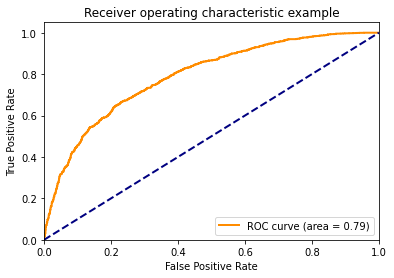

In [84]:
#Plot ROC Curve
plt.figure()
lw = 2
plt.plot(fprs, tprs, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()